Total number of sweeps: 1
Download sweep_id='sv9z59on' data...


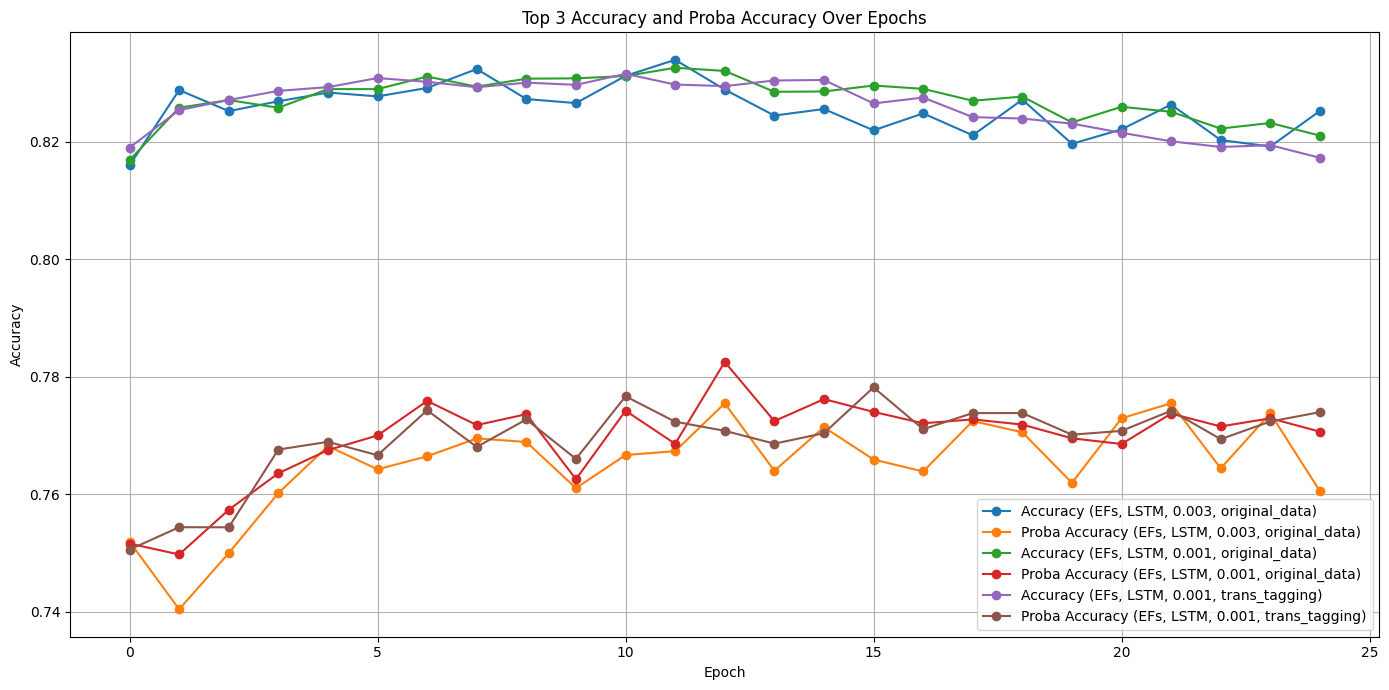

In [18]:
import pandas as pd
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics

directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

class wandb_results:
    def __init__(self, project_id, wandb_username="bellatomer"):
        self.api = wandb.Api(timeout=60)
        self.project_id = project_id
        self.wandb_username = wandb_username

    def get_sweep_results(self, sweep_id, metric="accuracy_all", best_epoch=False, get_servers=False, reset_api=False, read_csv_if_exist=True, save_to_csv=True):
        if reset_api:
            self.reset_api()

        print(f"Download {sweep_id=} data...")
        runs = self.api.sweep(f"{self.wandb_username}/{self.project_id}/{sweep_id}").runs
        n_runs = len(runs)
        path = f"sweeps_csvs/{sweep_id}_{n_runs}.csv"
        if read_csv_if_exist and os.path.exists(path):
            return pd.read_csv(path, index_col=0)
        summary_list, config_list, name_list = [], [], []
        for run in tqdm(runs):
            summary_list.append(run.summary._json_dict)
            config_list.append(
                {k: v for k,v in run.config.items()
                  if not k.startswith('_')})
            name_list.append(run.name)

        runs_df = pd.DataFrame({
            "summary": summary_list,
            "config": config_list,
            "name": name_list
            })
        config_cols = pd.json_normalize(runs_df['config'])
        config_cols.columns = [f"config_{c}" for c in config_cols.columns]
        summary_cols = pd.json_normalize(runs_df['summary'])
        runs_df = pd.concat([runs_df, config_cols, summary_cols], axis=1)
        runs_df.drop(['config', 'summary'], axis=1, inplace=True)
        hpt = [c for c in config_cols.columns if c not in ["config_seed", "config_run_hash"]]
        if save_to_csv: runs_df.to_csv(path)
        return runs_df

    def get_sweeps_results(self, sweeps, metric="accuracy_all", best_epoch=False, get_servers=False,  read_csv_if_exist=True, save_to_csv=True):
        print("Total number of sweeps:", len(sweeps))
        j = pd.concat([self.get_sweep_results(sweep, metric=metric, best_epoch=best_epoch,  get_servers=get_servers, save_to_csv=save_to_csv, read_csv_if_exist=read_csv_if_exist) for sweep in sweeps])
        j = j.reset_index(drop=True)
        return j

    def reset_api(self):
        self.api = wandb.Api()

def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric="accuracy_per_mean_user_and_bot", epoch="best"):
    api = wandb_results("NLP2024_PROJECT_BellaPerel", wandb_username="bellatomer")
    df = api.get_sweeps_results(sweeps, metric=metric)

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    #print(f"Hyperparameter columns (HPT_cols): {HPT_cols}")

    if drop_HPT:
        df = df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]
    #print(f"Numeric columns: {numeric_cols}")

    groupby_cols = [c for c in HPT_cols if c in df_numeric.columns and c != "config_seed"]
    #print(f"Grouping by columns: {groupby_cols}")

    if not groupby_cols:
        raise KeyError("None of the HPT columns are present in the numeric DataFrame")

    grouped = df_numeric.groupby(groupby_cols)

    mean_df = grouped.mean()
    std_df = grouped.std()

    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch == "best":
        metric_columns = [c for c in mean_df.columns if metric in c]
        #print(f"Metric columns that include '{metric}': {metric_columns}")
        if not metric_columns:
            raise ValueError("No columns match the specified metric for the 'best' epoch")
        best_col = mean_df[metric_columns].idxmax(axis=1)
    else:
        metric_columns = [c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]
        #print(f"Metric columns for epoch {epoch} that include '{metric}': {metric_columns}")
        if not metric_columns:
            raise ValueError(f"No columns match the specified metric for epoch {epoch}")
        best_col = mean_df[metric_columns].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())

    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best":
        df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df = summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound

BASE_METRIC = "accuracy_per_mean_user_and_bot"


def result_metric(sweeps, group_name, metric="accuracy_per_mean_user_and_bot"):
    api = wandb_results("NLP2024_PROJECT_BellaPerel", wandb_username="bellatomer")
    df = api.get_sweeps_results(sweeps, metric=metric)

    config_cols = [c for c in df.columns if "config_" in c and c != "config_wandb_run_id" and c != "config_online_simulation_size"]
    HPT_cols = ['config_seed', 'config_features', 'config_input_dim', 'config_REVIEW_DIM', 'config_architecture', 'config_FEATURES_PATH', 'config_ENV_LEARNING_RATE', 'config_offline_train_test_datasets']
    #print(f"Hyperparameter columns (HPT_cols): {HPT_cols}")

    groupby_cols = [c for c in HPT_cols if c in df.columns]
    #print(f"Grouping by columns: {groupby_cols}")

    if not groupby_cols:
        raise KeyError("None of the HPT columns are present in the DataFrame")

    metric_columns = [col for col in df.columns if metric in col]
    #print(f"Metric columns: {metric_columns}")

    selected_cols = groupby_cols + metric_columns
    df_selected = df[selected_cols]

    grouped_df = df_selected.groupby(groupby_cols).mean().reset_index()

    return grouped_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


sweeps = ["sv9z59on"]
group_name = "Group"
result_df = result_metric(sweeps, group_name, metric="accuracy_per_mean_user_and_bot")

csv_path = 'all_epochs_params.csv'
result_df.to_csv(csv_path, index=False)

#print("DataFrame with all configs and all epochs:")
#print(result_df)

import pandas as pd

HPT_cols = ['config_features', 'config_input_dim', 'config_REVIEW_DIM', 'config_architecture', 'config_FEATURES_PATH', 'config_ENV_LEARNING_RATE', 'config_offline_train_test_datasets']

df = pd.read_csv('all_epochs_params.csv')

metric_columns = [col for col in df.columns if "accuracy_per_mean_user_and_bot" in col]
#print(f"Metric columns: {metric_columns}")

grouped_df = df.groupby(HPT_cols + ['config_seed'])[metric_columns].mean().reset_index()

final_grouped_df = grouped_df.groupby(HPT_cols)[metric_columns].mean().reset_index()

csv_path_avg = 'averaged_params.csv'
final_grouped_df.to_csv(csv_path_avg, index=False)

#print("Averaged DataFrame:")
#print(final_grouped_df)


df = final_grouped_df
display_HPT_cols = ['config_features', 'config_architecture', 'config_ENV_LEARNING_RATE', 'config_offline_train_test_datasets']
proba_metric_columns = [col for col in df.columns if "ENV_Test_proba_accuracy_per_mean_user_and_bot" in col]
#print(f"Proba Metric columns: {proba_metric_columns}")
accuracy_metric_columns = [col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot" in col]
##print(df.columns)


# Function to extract epoch number from column name
def extract_epoch_number(col_name):
    try:
        return int(col_name.split('_')[-1][5:])
    except (IndexError, ValueError):
        return float('inf')  # Assign a large number if parsing fails to sort it at the end

proba_metric_columns = sorted([col for col in df.columns if "ENV_Test_proba_accuracy_per_mean_user_and_bot" in col and "epoch" in col], key=extract_epoch_number)
accuracy_metric_columns = sorted([col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot" in col and "epoch" in col], key=extract_epoch_number)




df['max_proba_accuracy'] = df[accuracy_metric_columns].max(axis=1)
top_3_df = df.nlargest(3, 'max_proba_accuracy')
#print(f"Accuracy Metric columns: {accuracy_metric_columns}")
plot_data = top_3_df[HPT_cols + accuracy_metric_columns + proba_metric_columns]

top_3_results_df = plot_data.copy()
csv_path_top3 = 'top_3_results.csv'
top_3_results_df.to_csv(csv_path_top3, index=False)

plt.figure(figsize=(14, 7))
for i, row in top_3_results_df.iterrows():
    epochs = range(len(accuracy_metric_columns))
    legend_label = ", ".join([f"{row[col]}" for col in display_HPT_cols])
    plt.plot(epochs, row[accuracy_metric_columns], label=f"Accuracy ({legend_label})", marker='o')
    plt.plot(epochs, row[proba_metric_columns], label=f"Proba Accuracy ({legend_label})", marker='o')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Top 3 Accuracy and Proba Accuracy Over Epochs")
plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
plt.grid(True)
plt.tight_layout()
plt.show()





In [16]:
table_data = []
for i, row in top_3_results_df.iterrows():
    max_accuracy = row[accuracy_metric_columns].astype(float).max() # Convert the values to float
    max_epoch_index = row[accuracy_metric_columns].astype(float).idxmax() # Convert the values to float
    max_epoch = int(max_epoch_index.split('_')[-1][5:])
    std_over_epochs = row[accuracy_metric_columns].astype(float).std() # Convert the values to float

    config_data = {col: row[col] for col in display_HPT_cols}
    config_data['Max Epoch'] = max_epoch
    config_data['Max Accuracy'] = max_accuracy
    config_data['Std Over Epochs'] = std_over_epochs

    table_data.append(config_data)

top_3_table_df = pd.DataFrame(table_data)

print("******************")
print("Top 3 ocnfigurations and their results, grouped and averaged by seed")
print("******************")
display(top_3_table_df)

csv_path_table = 'top_3_table.csv'
top_3_table_df.to_csv(csv_path_table, index=False)


******************
Top 3 ocnfigurations and their results, grouped and averaged by seed
******************


,config_features,config_architecture,config_ENV_LEARNING_RATE,config_offline_train_test_datasets,Max Epoch,Max Accuracy,Std Over Epochs
0,EFs,LSTM,0.003,original_data,11,0.833930,0.004312
1,EFs,LSTM,0.001,original_data,11,0.832573,0.003779
2,EFs,LSTM,0.001,trans_tagging,10,0.831539,0.004504
3,EFs,LSTM,0.003,original_data,11,0.833930,0.004312
4,EFs,LSTM,0.001,original_data,11,0.832573,0.003779
5,EFs,LSTM,0.001,trans_tagging,10,0.831539,0.004504
6,EFs,LSTM,0.003,original_data,11,0.833930,0.004312
7,EFs,LSTM,0.001,original_data,11,0.832573,0.003779
8,EFs,LSTM,0.001,trans_tagging,10,0.831539,0.004504


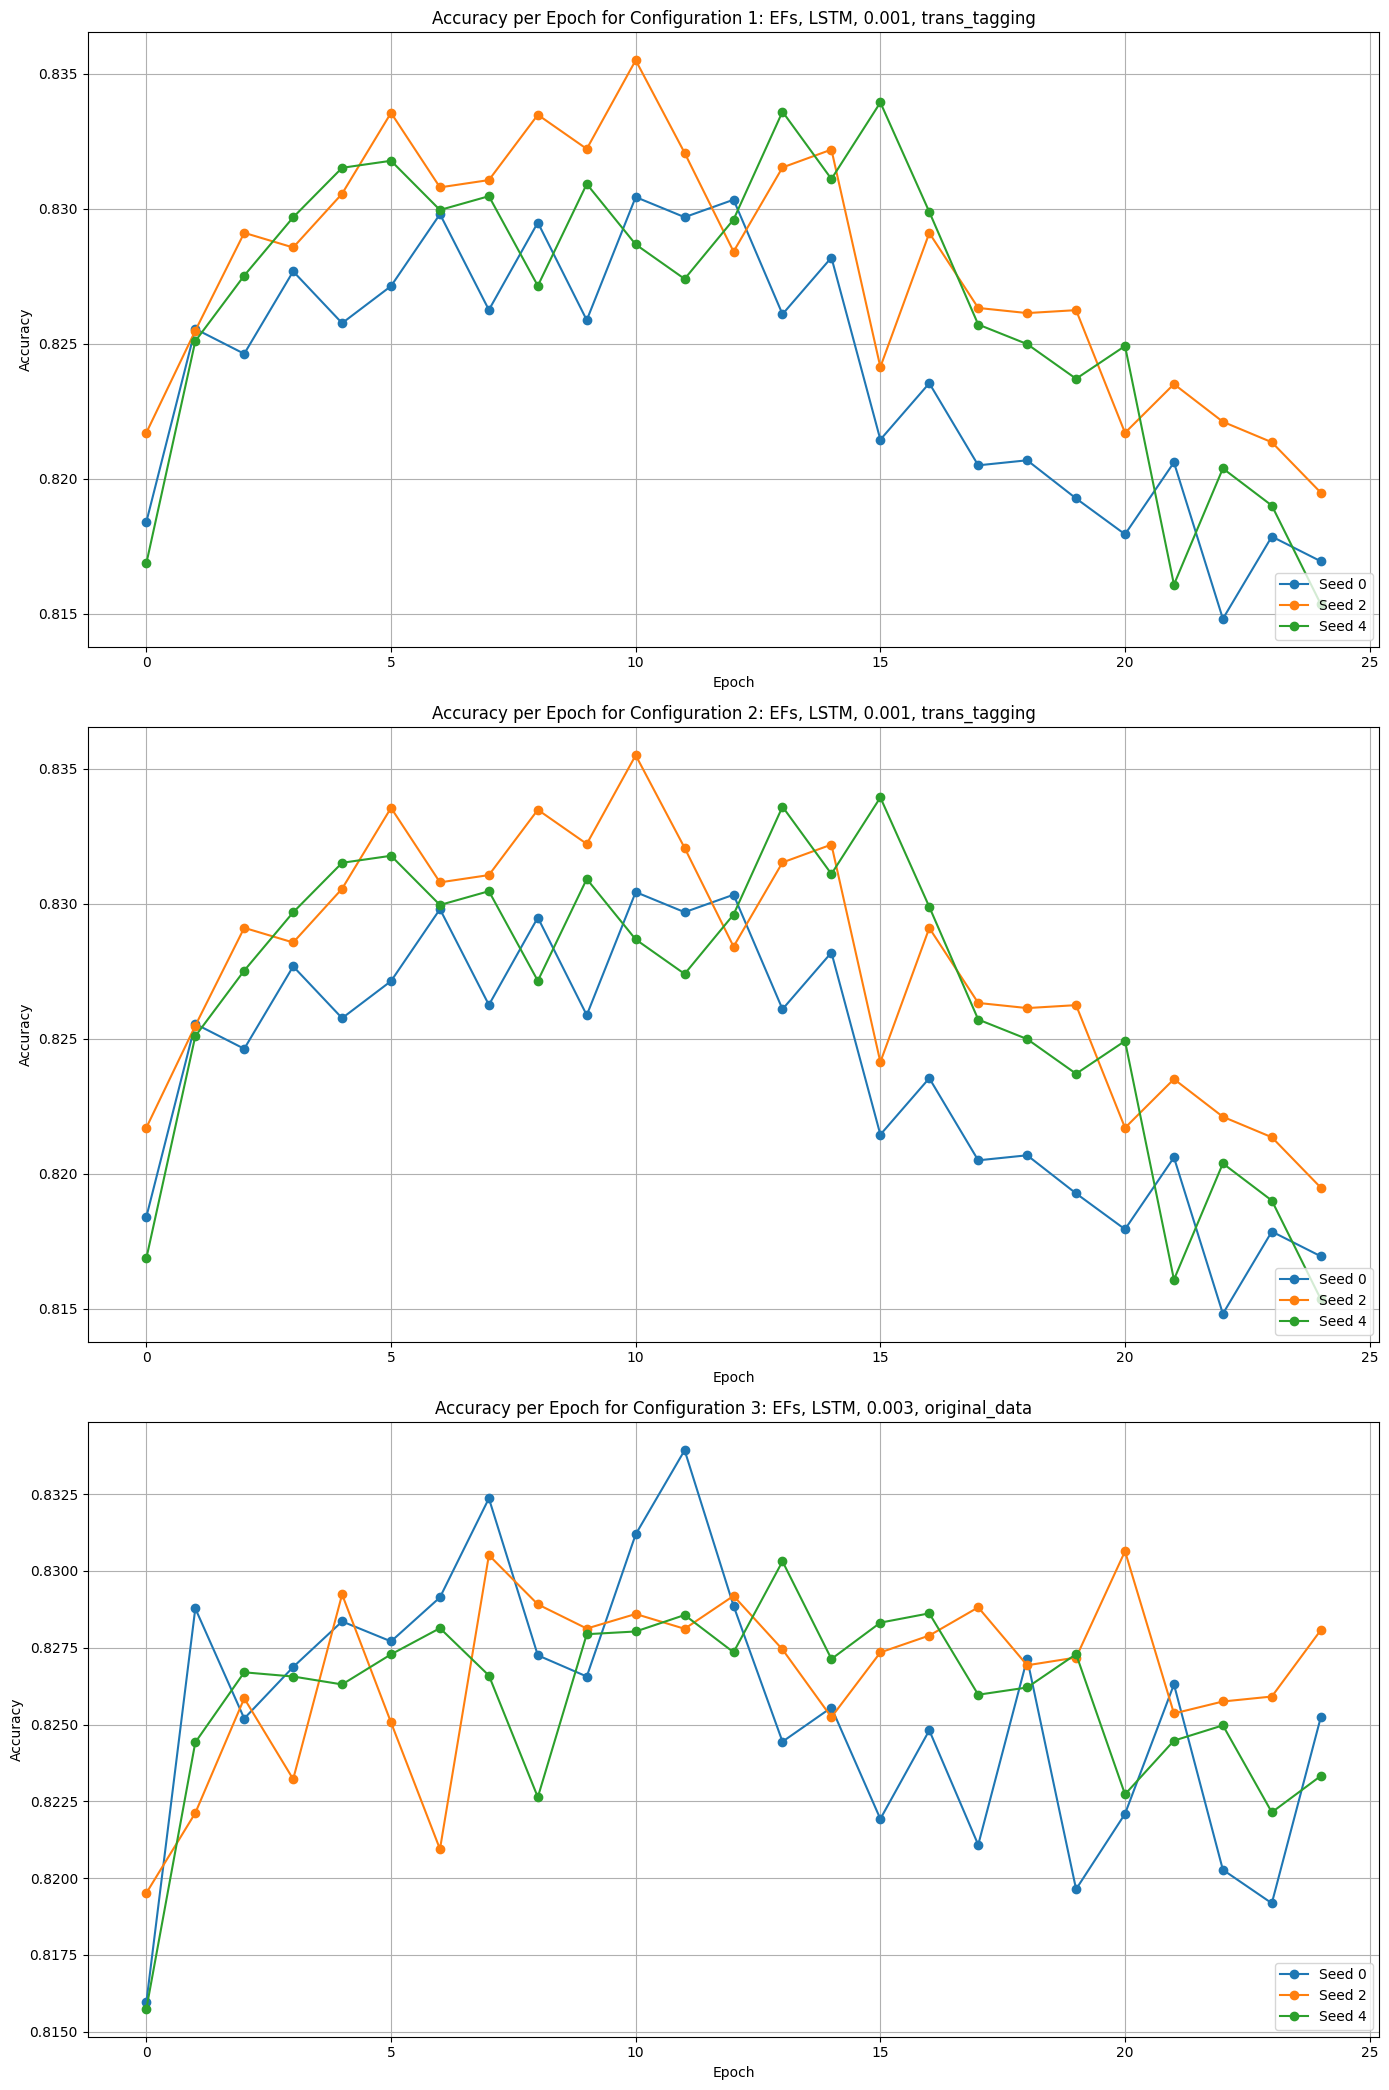

In [17]:
df = pd.read_csv('all_epochs_params.csv')

display_HPT_cols = ['config_features', 'config_architecture', 'config_ENV_LEARNING_RATE', 'config_offline_train_test_datasets']

def extract_epoch_number(col_name):
    try:
        return int(col_name.split('_')[-1][5:])
    except (IndexError, ValueError):
        return float('inf')

proba_metric_columns = sorted([col for col in df.columns if "ENV_Test_proba_accuracy_per_mean_user_and_bot" in col and "epoch" in col], key=extract_epoch_number)
accuracy_metric_columns = sorted([col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot" in col and "epoch" in col], key=extract_epoch_number)

df['max_proba_accuracy'] = df[accuracy_metric_columns].max(axis=1)
top_3_df = df.nlargest(3, 'max_proba_accuracy')

top_3_configs = top_3_df[display_HPT_cols]

plt.figure(figsize=(14, 21))  # Adjust the size for multiple subplots

for idx, (config_index, config_row) in enumerate(top_3_configs.iterrows(), 1):

    config_filter = (df[display_HPT_cols] == config_row).all(axis=1)
    filtered_df = df[config_filter]

    plt.subplot(3, 1, idx)

    for i, row in filtered_df.iterrows():
        epochs = list(range(len(accuracy_metric_columns)))
        legend_label = f"Seed {row['config_seed']}"

        plt.plot(epochs, row[accuracy_metric_columns], label=legend_label, marker='o')

    config_title = ", ".join([f"{config_row[col]}" for col in display_HPT_cols])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy per Epoch for Configuration {idx}: {config_title}")
    plt.legend(loc='lower right', bbox_to_anchor=(1, 0))
    plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:


df = pd.read_csv('all_epochs_params.csv')

display_HPT_cols = ['config_features', 'config_architecture', 'config_ENV_LEARNING_RATE', 'config_offline_train_test_datasets']

def extract_epoch_number(col_name):
    try:
        return int(col_name.split('_')[-1][5:])
    except (IndexError, ValueError):
        return float('inf')

accuracy_metric_columns = sorted([col for col in df.columns if "ENV_Test_accuracy_per_mean_user_and_bot" in col and "epoch" in col], key=extract_epoch_number)

results = []
grouped = df.groupby(display_HPT_cols)
for config, group in grouped:
    max_accuracy = -float('inf')
    max_seed = None
    max_epoch = None

    for _, row in group.iterrows():
        for col in accuracy_metric_columns:
            if row[col] > max_accuracy:
                max_accuracy = row[col]
                max_seed = row['config_seed']
                max_epoch = extract_epoch_number(col)


    result = {
        'Configuration': config,
        'Max Accuracy': max_accuracy,
        'Seed': max_seed,
        'Epoch': max_epoch
    }
    results.append(result)

max_results_df = pd.DataFrame(results)
print("******************")
print("Best results per config and their epochs")
print("******************")
display(max_results_df)

max_results_df.to_csv("max_results.csv", index=False)

plt.tight_layout()
plt.show()

******************
Best results per config and their epochs
******************


,Configuration,Max Accuracy,Seed,Epoch
0,"(EFs, CNN, 0.001, key_word_tagging)",0.821816,4,3
1,"(EFs, CNN, 0.001, original_data)",0.822250,4,1
2,"(EFs, CNN, 0.001, trans_tagging)",0.823900,2,4
3,"(EFs, CNN, 0.003, key_word_tagging)",0.821456,2,8
4,"(EFs, CNN, 0.003, original_data)",0.823800,0,4
5,"(EFs, CNN, 0.003, trans_tagging)",0.822489,4,4
6,"(EFs, LSTM, 0.001, key_word_tagging)",0.831633,2,8
7,"(EFs, LSTM, 0.001, original_data)",0.832573,0,11
8,"(EFs, LSTM, 0.001, trans_tagging)",0.835504,2,10
9,"(EFs, LSTM, 0.003, key_word_tagging)",0.831819,4,7


<Figure size 640x480 with 0 Axes>